In [1]:
import intake
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import fsspec
import os
import time
import datetime as dt

import warnings
# normally I dislike ingoring warnings, but there were too many mean of empty slice warnings to be useful
warnings.simplefilter('ignore')

xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
plt.rcParams['figure.figsize'] = 12, 6

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


## Load dask

In [2]:
from dask.distributed import Client, progress
from dask_kubernetes import KubeCluster
cluster = KubeCluster()
cluster.adapt(minimum=1, maximum=20)
cluster

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:   tcp://10.32.16.25:41281
distributed.scheduler - INFO -   dashboard at:                     :8787


In [3]:
client = Client(cluster)
client

distributed.scheduler - INFO - Receive client connection: Client-5b11f12e-9acf-11ea-8168-b62290b742fc
distributed.core - INFO - Starting established connection


Client Scheduler: tcp://10.32.16.25:41281 Dashboard: /user/0000-0003-3746-2383/proxy/8787/status,Cluster Workers: 20 Cores: 40 Memory: 230.00 GB


## Load data

In [4]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
cat = col.search(experiment_id=['historical'], variable_id='fgco2',
                 grid_label='gn', table_id='Omon')

In [5]:
dset_dict = {}
for name, group in cat.df.groupby('source_id'):
    dsets = [xr.open_zarr(fsspec.get_mapper(zstore), consolidated=True)
             for zstore in group.zstore.values]
    try:
        dsets_aligned = xr.align(*dsets, join='exact')
        dset_dict[name] = xr.concat(dsets, dim='member')
        print(f'concatted {name}')
    except Exception as e:
        print(f'failed to concat {name}')
        print(e)

concatted ACCESS-ESM1-5
concatted BCC-CSM2-MR
concatted BCC-ESM1
concatted CESM2
concatted CESM2-FV2
concatted CESM2-WACCM
concatted CESM2-WACCM-FV2
concatted CNRM-ESM2-1
concatted CanESM5
concatted CanESM5-CanOE
concatted GISS-E2-1-G
concatted GISS-E2-1-G-CC
concatted IPSL-CM6A-LR
concatted MIROC-ES2L
concatted MPI-ESM-1-2-HAM
concatted MPI-ESM1-2-HR
concatted MPI-ESM1-2-LR
concatted MRI-ESM2-0
concatted NorCPM1
concatted NorESM2-LM
concatted NorESM2-MM
failed to concat UKESM1-0-LL
indexes along dimension 'time' are not equal


In [15]:
ds = dset_dict['CESM2']
display(ds)

,Array,Chunk
Bytes,10.71 GB,58.98 MB
Shape,"(11, 1980, 384, 320)","(1, 120, 384, 320)"
Count,1121 Tasks,297 Chunks
Type,float32,numpy.ndarray


# The models have different labelling conventions
I want to make a loop to plot moving means for all the models, and need the different labels to be recognized

In [6]:
info = {}

for model in dset_dict.keys():
    info[model] = {}

# catalog the dimension and coordinate labels used in each model into a new dictionary
for key in dset_dict.keys():
    # longitude dimensions
    if dset_dict[key].dims.__contains__('j'):
        info[key]['dim_lon'] = 'j'
    elif dset_dict[key].dims.__contains__('x'):
        info[key]['dim_lon'] = 'x'
    elif dset_dict[key].dims.__contains__('lon'):
        info[key]['dim_lon'] = 'lon'
    elif dset_dict[key].dims.__contains__('nlon'):
        info[key]['dim_lon'] = 'nlon'
    else:
        print('dimension label unaccounted for')
    # latitude dimensions
    if dset_dict[key].dims.__contains__('i'):
        info[key]['dim_lat'] = 'i'
    elif dset_dict[key].dims.__contains__('y'):
        info[key]['dim_lat'] = 'y'
    elif dset_dict[key].dims.__contains__('lat'):
        info[key]['dim_lat'] = 'lat'
    elif dset_dict[key].dims.__contains__('nlat'):
        info[key]['dim_lat'] = 'nlat'
    else:
        print('dimension label unaccounted for', key)
    # longitude coordinates
    if dset_dict[key].coords.__contains__('longitude'):
        info[key]['coords_lon'] = 'longitude'
    elif dset_dict[key].coords.__contains__('lon'):
        info[key]['coords_lon'] = 'lon'
    elif dset_dict[key].coords.__contains__('x'):
        info[key]['coords_lon'] = 'x'
    elif dset_dict[key].coords.__contains__('nav_lon'):
        info[key]['coords_lon'] = 'nav_lon'
    else:
        print('coordinate label unnacounted for', key)
    # latitude coordinates
    if dset_dict[key].coords.__contains__('latitude'):
        info[key]['coords_lat'] = 'latitude'
    elif dset_dict[key].coords.__contains__('lat'):
        info[key]['coords_lat'] = 'lat'
    elif dset_dict[key].coords.__contains__('y'):
        info[key]['coords_lat'] = 'y'
    elif dset_dict[key].coords.__contains__('nav_lat'):
        info[key]['coords_lat'] = 'nav_lat'
    else:
        print('coordinate label unnacounted for', key)

In [7]:
# taking a look at a model's dimension and coordinate names
list(info)[0], info[list(info)[0]]

('ACCESS-ESM1-5',
 {'dim_lon': 'j',
  'dim_lat': 'i',
  'coords_lon': 'longitude',
  'coords_lat': 'latitude'})

# Function to calculate moving mean of a model

In [8]:
def movingmean(model, dim_lon, dim_lat, coords_lon, coords_lat, window=70):
    '''
    Calculates a rolling-window/moving mean of Surface 
    Downward Flux of Total CO2 (fgco2) from 1850 to 2014
    
    The CMIP6 models have different naming conventions for
    lon and lat coordinates, such as 'x/y' or 'i/j' or 
    'nlat/nlon'. This function takes this into account
    
    Parameters
    ----------
    model: str
        model name in CMIP6 that contains fgco2 data
    lon: str
        name of longitude dimension used in model
    lat: str
        name of latitude dimension used in model
    window: int
        moving mean window size in years
        
    Returns
    -------
    result: xarray.DataArray
        moving mean time series
        
    
    '''
    ds = dset_dict[model]

    ds_band = ds.where((ds[coords_lat] < 10) & (ds[coords_lat] > -10) & (ds[coords_lon] > 110) & (ds[coords_lon] < 290),drop=True)


    # 17780 km from 110E to 290E, at 10N latitude
    # 2222 km from 10N to 10S
    A = 2222e3 * 17780e3 # m2
    s2yr = 3600*24*365 # convert from per second to per year

    # select fgco2 variable and convert units from kg/m2/s to Pg C/yr
    ds_band = ds_band.fgco2 * A * s2yr * 1e-12

    # N year rolling window
    result = ds_band.resample(time='1Y').mean().chunk({'time':-1}).rolling(time=window,center=True).mean().load()
    result = result.mean(dim='member')
    result = result.mean(dim=[dim_lat,dim_lon]).dropna(dim='time')
        
    return result

# For loop to loop through the models in this subset of CMIP6

In [9]:
for key in info.keys():
    model, lon, lat, clon, clat = key, info[key]['dim_lon'], info[key]['dim_lat'], info[key]['coords_lon'], info[key]['coords_lat']
    info[key]['70yr_mean'] = movingmean(model,lon,lat,clon,clat, window=70)
    print(key)

ACCESS-ESM1-5
BCC-CSM2-MR
BCC-ESM1
CESM2
CESM2-FV2
CESM2-WACCM
CESM2-WACCM-FV2
CNRM-ESM2-1


distributed.core - INFO - Event loop was unresponsive in Scheduler for 8.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


CanESM5
CanESM5-CanOE
GISS-E2-1-G
GISS-E2-1-G-CC


distributed.core - INFO - Event loop was unresponsive in Scheduler for 5.27s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


IPSL-CM6A-LR
MIROC-ES2L
MPI-ESM-1-2-HAM
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.core - INFO - Event loop was unresponsive in Scheduler for 5.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


NorCPM1
NorESM2-LM


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


NorESM2-MM


Text(0, 0.5, 'fgco2 [PgC/yr]')

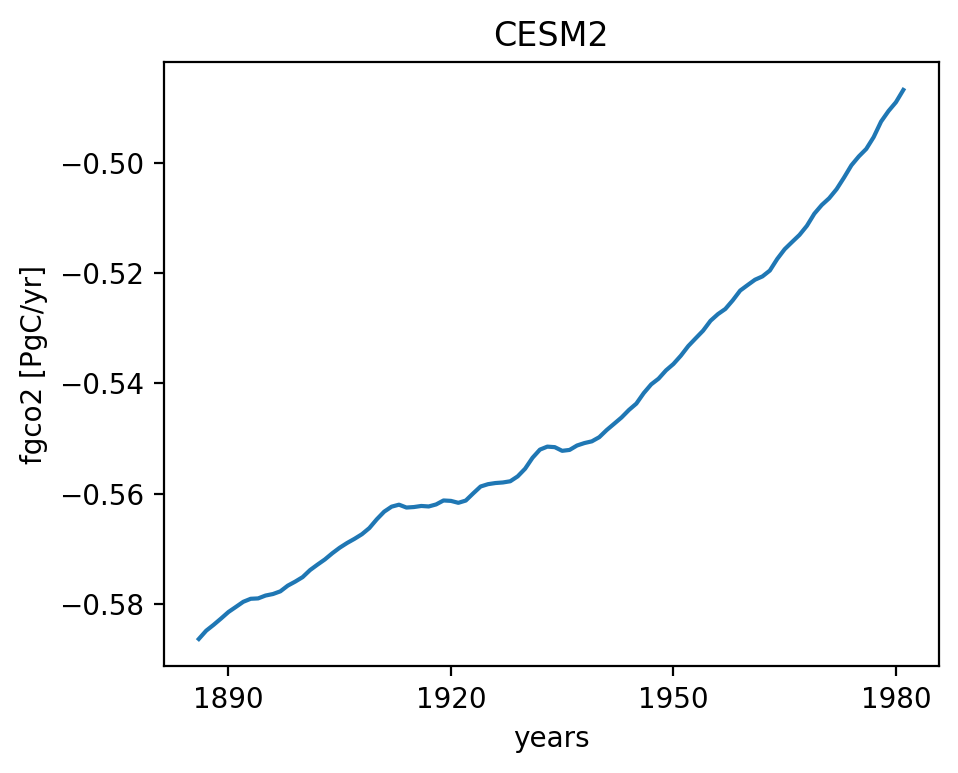

In [10]:
fig, ax = plt.subplots(figsize=(5,4),dpi=100)
info['CESM2']['70yr_mean'].plot(ax=ax)
ax.set_title('CESM2')
ax.set_xlabel('years')
ax.set_ylabel('fgco2 [PgC/yr]')

# Plot all the models

In [11]:
dset_dict.keys()

dict_keys(['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'BCC-ESM1', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'CNRM-ESM2-1', 'CanESM5', 'CanESM5-CanOE', 'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MPI-ESM-1-2-HAM', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NorCPM1', 'NorESM2-LM', 'NorESM2-MM'])

In [12]:
subset = dset_dict
del subset['BCC-CSM2-MR']    # no data
del subset['BCC-ESM1']       # no data
del subset['GISS-E2-1-G']    # magnitude issue
del subset['GISS-E2-1-G-CC'] # magnitude issue
del subset['NorCPM1']        # has a longer time series?

In [13]:
sumtrends = 0
for mod in subset.keys():
    sumtrends += info[mod]['70yr_mean'].values
    print(mod)
    
mean_of_models = sumtrends/len(subset.keys())

ACCESS-ESM1-5
CESM2
CESM2-FV2
CESM2-WACCM
CESM2-WACCM-FV2
CNRM-ESM2-1
CanESM5
CanESM5-CanOE
IPSL-CM6A-LR
MIROC-ES2L
MPI-ESM-1-2-HAM
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0
NorESM2-LM
NorESM2-MM


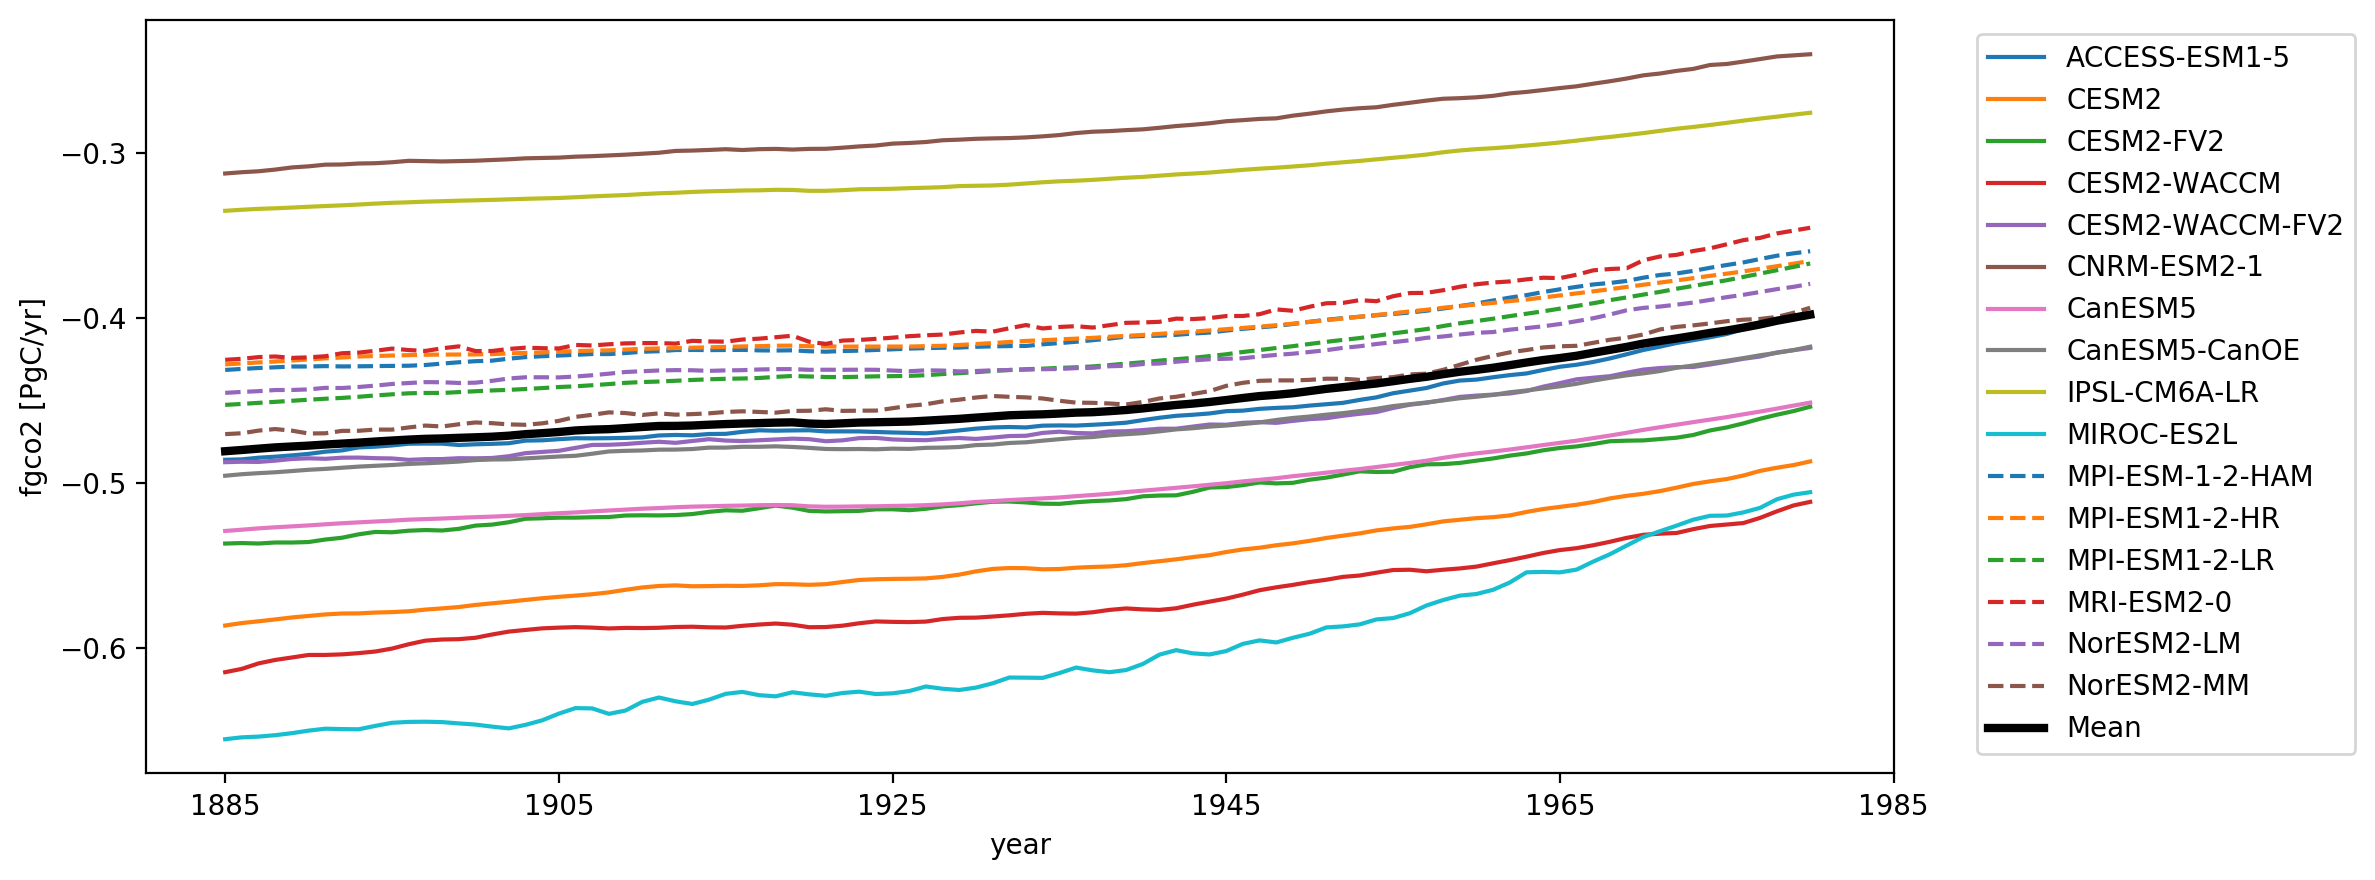

In [22]:
trend = '70yr_mean'

fig, ax = plt.subplots(figsize=(12,4.5),dpi=100)

plt.plot(info['ACCESS-ESM1-5'][trend],label='ACCESS-ESM1-5')
plt.plot(info['CESM2'][trend],label='CESM2')
plt.plot(info['CESM2-FV2'][trend],label='CESM2-FV2')
plt.plot(info['CESM2-WACCM'][trend],label='CESM2-WACCM')
plt.plot(info['CESM2-WACCM-FV2'][trend],label='CESM2-WACCM-FV2')
plt.plot(info['CNRM-ESM2-1'][trend],label='CNRM-ESM2-1')
plt.plot(info['CanESM5'][trend],label='CanESM5')
plt.plot(info['CanESM5-CanOE'][trend],label='CanESM5-CanOE')
# GISS models are a magnitude larger
# plt.plot(info['GISS-E2-1-G']['70yr_mean'],label='GISS-E2-1-G')
# plt.plot(info['GISS-E2-1-G-CC']['70yr_mean'],label='GISS-E2-1-G-CC')
plt.plot(info['IPSL-CM6A-LR'][trend],label='IPSL-CM6A-LR')
plt.plot(info['MIROC-ES2L'][trend], label='MIROC-ES2L')
plt.plot(info['MPI-ESM-1-2-HAM'][trend],label='MPI-ESM-1-2-HAM',ls='--')
plt.plot(info['MPI-ESM1-2-HR'][trend],label='MPI-ESM1-2-HR',ls='--')
plt.plot(info['MPI-ESM1-2-LR'][trend],label='MPI-ESM1-2-LR',ls='--')
plt.plot(info['MRI-ESM2-0'][trend], label='MRI-ESM2-0',ls='--')
# Extended time series model? ignore for now
# plt.plot(info['NorCPM1'][trend],label='NorCPM1',ls='--')
plt.plot(info['NorESM2-LM'][trend],label='NorESM2-LM',ls='--')
plt.plot(info['NorESM2-MM'][trend],label='NorESM2-MM',ls='--')
# BCC models had no values

plt.plot(mean_of_models,lw=3,color='k', label='Mean')

# 10 year mean ticks
# plt.xticks(np.arange(0,156,25),labels=[1855,1880,1905,1930,1955,1980,2005])
# 70 year mean ticks
plt.xticks(np.arange(0,101,20),labels=[1885,1905,1925,1945,1965,1985])
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

plt.xlabel('year')
plt.ylabel('fgco2 [PgC/yr]')
plt.tight_layout()
# plt.savefig('70yr_movingmean_fgco2_CMIP6')

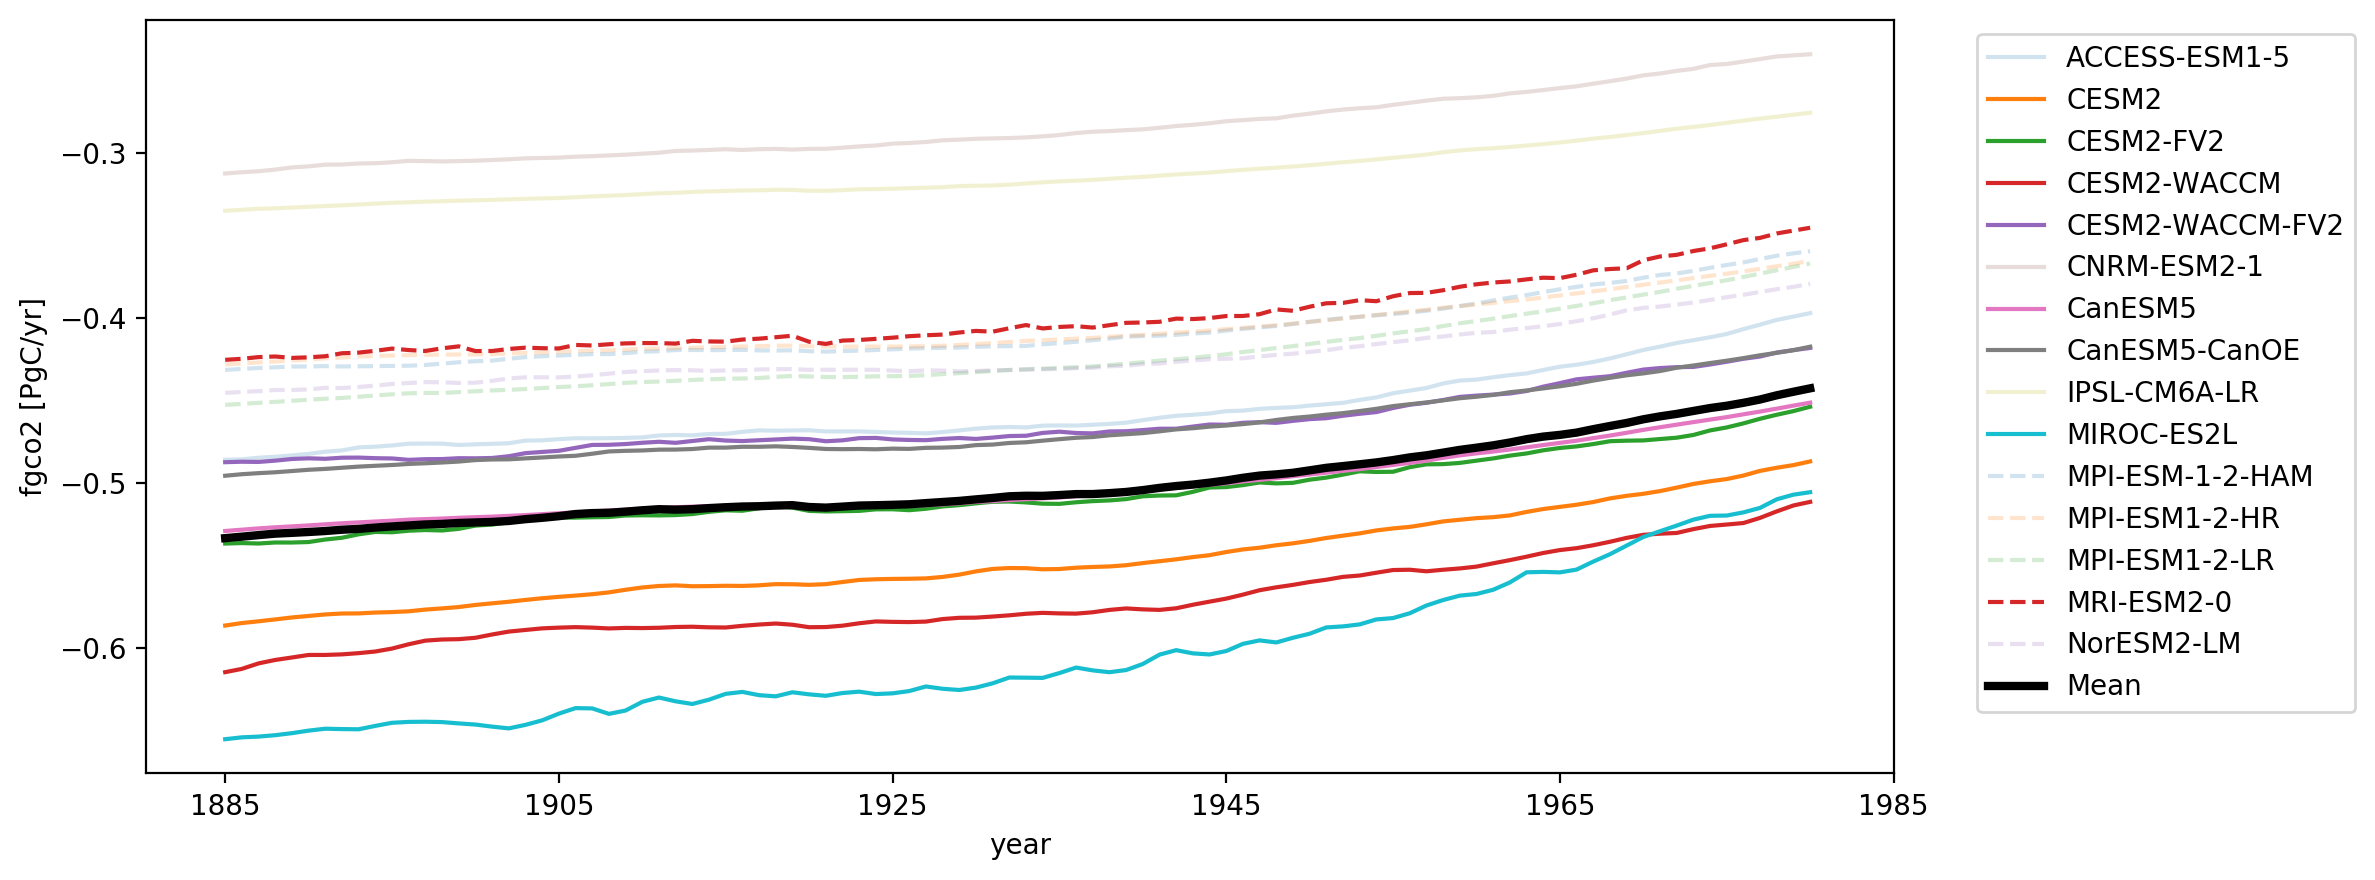

In [20]:
# ACCORDING TO DONG ET AL. 2016, there were only 6 models that captured the ENSO mode in the tropical Pacific and global ocean.
# I will reduce the opacity of the models that aren't related to those 6 models.

subset2 = subset
del subset2['ACCESS-ESM1-5']
del subset2['CNRM-ESM2-1']
del subset2['IPSL-CM6A-LR']
del subset2['MPI-ESM-1-2-HAM']
del subset2['MPI-ESM1-2-HR']
del subset2['MPI-ESM1-2-LR']
del subset2['NorESM2-LM']

trend = '70yr_mean'

sumtrends = 0
for mod in subset2.keys():
    sumtrends += info[mod][trend].values    
mean_of_models = sumtrends/len(subset2.keys())

fig, ax = plt.subplots(figsize=(12,4.5),dpi=100)

plt.plot(info['ACCESS-ESM1-5'][trend],label='ACCESS-ESM1-5',alpha=0.2)
plt.plot(info['CESM2'][trend],label='CESM2')
plt.plot(info['CESM2-FV2'][trend],label='CESM2-FV2')
plt.plot(info['CESM2-WACCM'][trend],label='CESM2-WACCM')
plt.plot(info['CESM2-WACCM-FV2'][trend],label='CESM2-WACCM-FV2')
plt.plot(info['CNRM-ESM2-1'][trend],label='CNRM-ESM2-1',alpha=0.2)
plt.plot(info['CanESM5'][trend],label='CanESM5')
plt.plot(info['CanESM5-CanOE'][trend],label='CanESM5-CanOE')
# GISS models are a magnitude larger
# plt.plot(info['GISS-E2-1-G']['70yr_mean'],label='GISS-E2-1-G')
# plt.plot(info['GISS-E2-1-G-CC']['70yr_mean'],label='GISS-E2-1-G-CC')
plt.plot(info['IPSL-CM6A-LR'][trend],label='IPSL-CM6A-LR',alpha=0.2)
plt.plot(info['MIROC-ES2L'][trend], label='MIROC-ES2L')
plt.plot(info['MPI-ESM-1-2-HAM'][trend],label='MPI-ESM-1-2-HAM',ls='--',alpha=0.2)
plt.plot(info['MPI-ESM1-2-HR'][trend],label='MPI-ESM1-2-HR',ls='--',alpha=0.2)
plt.plot(info['MPI-ESM1-2-LR'][trend],label='MPI-ESM1-2-LR',ls='--',alpha=0.2)
plt.plot(info['MRI-ESM2-0'][trend], label='MRI-ESM2-0',ls='--')
# Extended time series model? ignore for now
# plt.plot(info['NorCPM1'][trend],label='NorCPM1',ls='--')
plt.plot(info['NorESM2-LM'][trend],label='NorESM2-LM',ls='--',alpha=0.2)
# plt.plot(info['NorESM2-MM'][trend],label='NorESM2-MM',ls='--',alpha=0.2)

# BCC models had no values

plt.plot(mean_of_models,lw=3,color='k', label='Mean')

# 10 year mean ticks
# plt.xticks(np.arange(0,156,25),labels=[1855,1880,1905,1930,1955,1980,2005])
# 70 year mean ticks
plt.xticks(np.arange(0,101,20),labels=[1885,1905,1925,1945,1965,1985])
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

plt.xlabel('year')
plt.ylabel('fgco2 [PgC/yr]')
plt.tight_layout()
plt.savefig('70yr_movingmean_fgco2_CMIP6_basedonDONG2016study')